In [1]:
from astropy.io import fits
import jax
import jax.numpy as jnp
import sys

import os
import datetime
import glob
import h5py

sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
import scipy.constants as c

import astropy.units as u
import astropy.time as at
import astropy.coordinates as acoord

sys.path.append('..')
import jabble.dataset
import jabble.quickplay
import jabble.loss
import jabble.dataset
import jabble.model
import jabble.physics

jax.config.update("jax_enable_x64", True)

In [2]:
today = datetime.date.today()
out_dir = os.path.join('/scratch/mdd423/wobble_jax','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
ccf_files = glob.glob('/scratch/mdd423/wobble_jax/data/HD4307_harps/archive-8/*_ccf*.fits')
e2ds_sci = glob.glob('/scratch/mdd423/wobble_jax/data/HD4307_harps/archive-8/*e2ds_A*.fits')
e2ds_cal = glob.glob('/scratch/mdd423/wobble_jax/data/HD4307_harps/archive-8/*e2ds_B*.fits')

s1d_sci = glob.glob('/scratch/mdd423/wobble_jax/data/HD4307_harps/archive-8/*s1d_A*.fits')
s1d_cal = glob.glob('/scratch/mdd423/wobble_jax/data/HD4307_harps/archive-8/*s1d_B*.fits')


# print(len(ccf_files),len(e2ds_A_files),len(e2ds_B_files),len(s1d_sci),len(s1d_cal))

In [4]:
ccfstbl = fits.open(ccf_files[0])
e2dstbl_sci = fits.open(e2ds_sci[2])
e2dstbl_cal = fits.open(e2ds_cal[0])
s1dscitbl = fits.open(s1d_sci[0])
s1dcaltbl = fits.open(s1d_cal[0])

In [5]:
ccfstbl[0].header["*BERV*"]
print(len(e2ds_sci),len(ccf_files))
ccf_arr = np.zeros(shape=(0),dtype=[('times',np.double),('ccf_rvs',np.double),('ccf_rvc',np.double),('ccf_drvs',np.double),('bervs',np.double),('object','U64')])
for file, ccf_file in zip(e2ds_sci,ccf_files):
    with fits.open(file) as hdu:
        with fits.open(ccf_file) as ccfhdu:
            
            ccf_row = np.array([(ccfhdu[0].header['MJD-OBS'],1000*ccfhdu[0].header['HIERARCH ESO DRS CCF RV'],1000*ccfhdu[0].header['HIERARCH ESO DRS CCF RVC'],\
                                 np.double(ccfhdu[0].header['HIERARCH ESO DRS DVRMS']),1000*np.double(ccfhdu[0].header['HIERARCH ESO DRS BERV']),\
                                ccfhdu[0].header['OBJECT'])],\
                               dtype=[('times',np.double),('ccf_rvs',np.double),('ccf_rvc',np.double),\
                                      ('ccf_drvs',np.double),('bervs',np.double),('object','U64')])
            ccf_arr = np.concatenate((ccf_arr,ccf_row))

92 92


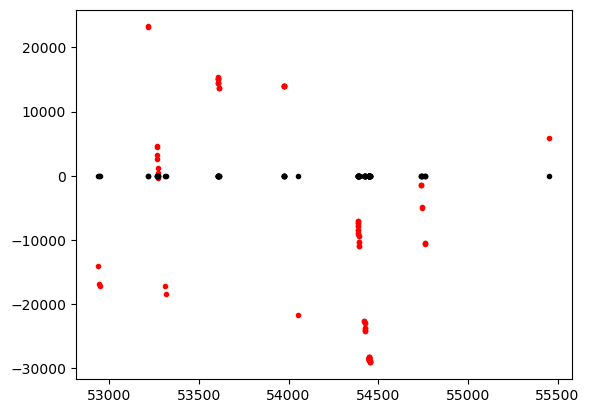

In [6]:
ccf_arr['ccf_rvs'],ccf_arr['object']
plt.errorbar(ccf_arr['times'],ccf_arr['ccf_rvs'] - ccf_arr['ccf_rvc'],ccf_arr['ccf_drvs'],fmt='.k')
plt.plot(ccf_arr['times'],ccf_arr['bervs'],'.r')

plt.show()

In [7]:
def wavelength_solution(x_pix,A,order_num,d):
    temp = np.array([x_pix**i * A[i + (order_num * (d+1))] for i in range(d+1)])
    return temp.sum(axis=0)

In [8]:
def get_wavelength_solution(file):
    d = file.header['ESO DRS CAL TH DEG LL']
    tot_orders = file.header['NAXIS2']
    
    A = []
    for index in range((d+1)*tot_orders):
        key = 'ESO DRS CAL TH COEFF LL{}'.format(index)
        A.append(file.header[key])
    A = np.array(A)
    
    x_pix = np.arange(0,file.header['NAXIS1'],step=1.0)
    wavelength_arr = np.zeros(file.data.shape)
    for iii in range(wavelength_arr.shape[0]):
        wavelength_arr[iii,:] = wavelength_solution(x_pix,A,iii,d)

    return wavelength_arr

Holy shit it works yes yesy yes yes

In [9]:
# wavelength_arr = get_wavelength_solution(e2dstbl_sci[0])
# flux_arr  = np.array(e2dstbl_sci[0].data)
# time = e2dstbl_sci[0].header['MJD-OBS']
# ccf_row = ccf_arr[ccf_arr['times'] == time]

# plt_order = 67
# # plt.plot(np.arange(0,wavelength_arr[plt_order,:].shape[0]),wavelength_arr[plt_order,:],'-b',alpha=0.4)
# # plt.show()
# halpha = 6562.8

# velocity_test = ccf_row['ccf_rvs']
# shift_test = halpha*velocity_test/c.c
# print(shift_test,c.c,ccf_row['bervs'])
# plt.plot(wavelength_arr[plt_order,:],np.log(flux_arr[plt_order,:]),'.k')
# plt.xlim(wavelength_arr[plt_order,:].min(),wavelength_arr[plt_order,:].max())


# plt.vlines([halpha + shift_test],ymin=(np.log(flux_arr[plt_order,:])).min(),ymax=(np.log(flux_arr[plt_order,:])).max())
# plt.xlim(6560,6570)

# plt.show()

In [10]:
def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping

    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do

    Returns:
        The value of the continuum at the wavelengths in x
        Author: Megan Bedell

    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w, _, _, _ = np.linalg.lstsq(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        # print(m.shape,m_new.shape)
        m = m_new
    return mu

def get_dataset(files,device,orders,obj_name,l_index,h_index,epsilon=np.exp(-11)):
    ys = []
    xs = []
    yivar = []
    mask = []

    bcs = []
    airmass = []
    times = []
    star_ids = []

    # fig, axes = plt.subplots(3,figsize=(9,9))
    for file in files:
        with fits.open(file) as hdu:
            if hdu[0].header['OBJECT'] == obj_name:
                wave_arr = get_wavelength_solution(hdu[0])
                for order in orders:
                    flux = np.array(hdu[0].data[order,:])
                    # flux -= flux.min()
                    # flux += epsilon
                    wave = np.log(wave_arr[order,:])
                    # wave = np.log(np.array(hdu[1].data["WAVE"][0,index_1:index_2]))
                    # err  = np.array(hdu[1].data["ERR"][0,index_1:index_2])/np.array(hdu[1].data["FLUX"][0,index_1:index_2])
                    err = np.ones(wave.shape) / hdu[0].header['HIERARCH ESO DRS SPE EXT SN{}'.format(order)]
                    ma = np.isnan(err) | np.isinf(err) | np.isinf(flux) | (flux <= epsilon) | np.isnan(flux)
                    # clean this shit
                    flux[ma] = 1.0
                    info     = 1/err**2
                    info[ma] = 0.0
                    wave[ma] = np.min(wave)

                    contin = fit_continuum(wave, np.log(flux), info, order=6, nsigma=[0.3,3.0], maxniter=50)
                    
                    ys.append((np.log(flux) - contin)[l_index:h_index])
                    xs.append(wave[l_index:h_index])
                    
                    yivar.append(info[l_index:h_index])
                    mask.append(ma.astype(bool)[l_index:h_index])
                    times.append(hdu[0].header["MJD-OBS"])
    
    #                 HIERARCH ESO TEL GEOELEV     =         2400. / Elevation above sea level (m)    
    # HIERARCH ESO TEL GEOLAT      =     -29.2584 / Tel geo latitute (+=North) (deg)  
    # HIERARCH ESO TEL GEOLON
                    
                    harps = acoord.EarthLocation.from_geodetic(lat=hdu[0].header["HIERARCH ESO TEL GEOLAT"],lon=hdu[0].header["HIERARCH ESO TEL GEOLON"],\
                                                height=hdu[0].header["HIERARCH ESO TEL GEOELEV"])
                    sc    = acoord.SkyCoord(ra=hdu[0].header["RA"]*u.deg, dec=hdu[0].header["DEC"]*u.deg)
                    barycorr = sc.radial_velocity_correction(obstime=at.Time(hdu[0].header["MJD-OBS"],format='mjd'), location=harps)
                    bcs.append(barycorr.to(u.m/u.s).value)
                    
                    try:
                        
                        airmass.append(hdu[0].header["AIRMASS"])
                    except KeyError:
                        altz = sc.transform_to(acoord.AltAz(obstime=at.Time(hdu[0].header["MJD-OBS"],format='mjd'),location=harps))
        
                        airmass.append(altz.secz)
                    star_ids.append(str(file))
    # plt.show()
    dataset = jabble.dataset.Data.from_lists(xs,ys,yivar,mask)
    
    dataset.metadata['times']    = jnp.array(times)
    dataset.metadata['star_ids'] = np.array(star_ids)
    dataset.metadata['bcs']      = jnp.array(bcs)
    dataset.metadata['airmass']  = jnp.array(airmass)
    dataset.to_device(device)
    
    # init_shifts = jax.device_put(init_shifts,device)
    # airmass = jax.device_put(airmass,device)
    
    return dataset

In [12]:
cpus = jax.devices("cpu")
# gpus = jax.devices("gpu")

In [13]:
# dataset = get_dataset(e2ds_sci,cpus[0],[23],'HD4307')

In [14]:
def get_normalization_model(dataset, norm_p_val: int, norm_pts: int):
    len_xs = np.max(
        [np.max(dataframe.xs) - np.min(dataframe.xs) for dataframe in dataset]
    )
    min_xs = np.min([np.min(dataframe.xs) for dataframe in dataset])
    max_xs = np.max([np.max(dataframe.xs) for dataframe in dataset])

    shifts = jnp.array([dataframe.xs.min() - min_xs for dataframe in dataset])
    print(-np.exp(min_xs)+np.exp(max_xs))
    # x_num = int((np.exp(max_xs) - np.exp(min_xs)) * pts_per_wavelength)
    x_spacing = len_xs / norm_pts
    x_grid = jnp.linspace(-x_spacing*((norm_p_val + 1)//2), len_xs + (x_spacing*((norm_p_val + 1)//2)), norm_pts + norm_p_val + 1) + min_xs
    print(np.average(np.diff(np.exp(x_grid))))
    # print(
    model = jabble.model.CardinalSplineMixture(x_grid, norm_p_val)
    size = len(dataset)

    p = jnp.tile(model.p, size)
    norm_model = jabble.model.NormalizationModel(p, model, size)
    return jabble.model.ShiftingModel(shifts).composite(norm_model)
# norm_model = get_normalization_model(dataset,norm_p_val,3)

In [15]:
def get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_vels,airmass):
         
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = jnp.arange(np.min(np.concatenate(dataset.xs)), np.max(np.concatenate(dataset.xs)), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    # model = jabble.quickplay.get_wobble_model(init_rvs, airmass, model_grid, p_val,rest_vels) #+ jabble.quickplay.get_normalization_model(dataset,norm_p_val,pts_per_wavelength)

    # model = jabble.quickplay.PseudoNormalModel(init_shifts, init_airmass, model_grid, p_val, dataset, norm_p_val, pts_per_wavelength)
    init_shifts = jabble.physics.shifts(init_rvs)
    rest_shifts = jabble.physics.shifts(rest_vels)
    model = jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(init_shifts,which_key='times'),#ShiftingModel(init_shifts),#
            jabble.model.CardinalSplineMixture(model_grid, p_val),
        ]
    ) + jabble.model.CompositeModel(
        [
            jabble.model.ShiftingModel(rest_shifts,which_key='times'),
            jabble.model.CardinalSplineMixture(model_grid, p_val),
            jabble.model.StretchingModel(airmass),
        ]
    )

    # model.to_device(device)

    # model.fit(2)
    # print(type(model.get_parameters()),model.get_parameters().devices())
    return model

In [16]:
def train_norm(model, dataset, loss, device_store, device_op, batch_size,nsigma = [0.5,2], maxiter=3):
    options = {"maxiter": 4096,\
               "factr": 1e4,\
              }
    # Fit Normalization Template
    for iii in range(maxiter):
        model.fix()
        model.fit(2, 1)
        
        res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
        print(res1)
        model.fix()
        _,metablock = dataset.blockify(device_op)
        for data_epoch in range(len(dataset)):

            mask    = dataset[data_epoch].mask
            metarow = jabble.loss.dict_ele(metablock,data_epoch,device_op)
            resid = dataset[data_epoch].ys - model([],dataset[data_epoch].xs,metarow)
            sigma = np.sqrt(np.nanmedian(resid**2))
            m_new = (resid < -nsigma[0]*sigma) | (resid > nsigma[1]*sigma)
            dataset[data_epoch].mask = mask | m_new[:len(mask)]

    return model

def train_cycle(model, dataset, loss, device_store, device_op, batch_size):
    options = {"maxiter": 8,\
               "factr": 10.0,\
              }

    # Fit Stellar & Telluric Template
    model.fix()
    model.fit(0,1)
    model.fit(1,1)
    model.display()
    
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)
    
    # Fit RV
    model.fix()
    model.fit(0,0)
    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)
    print(res1)

    # RV Parabola Fit
    model.fix()
    search_space = np.linspace(-100, 100, 500)
    shift_search = jabble.physics.shifts(search_space)

    sgrid = model[0][0].p[:,None] + shift_search[None,:]
    lgrid = model[0][0].grid_search(sgrid, loss, model, dataset, device_op)
    
    for i in range(lgrid.shape[0]):
        if np.argmin(lgrid[i,:]) == 0 or np.argmin(lgrid[i,:]) == lgrid.shape[1] - 1:
            plt.plot(shift_search,lgrid[i,:])
            plt.show()
    
    model[0][0].parabola_fit(shift_search, loss, model, dataset, device_op, device_store)
    model.to_device(device_op)

    # Fit Everything
    model.fix()
    model.fit(0,0)
    model.fit(0,1)
    model.fit(1,1)
    # model.fit(2,1)

    res1 = model.optimize(loss, dataset, device_store, device_op, batch_size, options=options)#model.optimize(loss, dataset)
    print(res1)

    return model

In [17]:
resolution = 115_000
p_val = 3
vel_padding = 100 * u.km / u.s

lmb = 1e-6

norm_p_val = 2
norm_pts   = 3

l_index = 50
h_index = 4095 - 50

star_name = 'HD4307'
os.makedirs(os.path.join(out_dir,star_name),exist_ok=True)

<h2>Work Horse</h2>
First we have to cut some of the data that is not the correct object. Then loop through loading the datasets, fitting models, and saving each bit.

In [18]:
ccf_arr_obj = ccf_arr[ccf_arr['object'] == star_name]
orders_s = np.arange(0,72,dtype=int).reshape(-1,2)
print(out_dir)

/scratch/mdd423/wobble_jax/out/25-10-16


36 36
-AdditiveModel------------------------------------0
  0-CompositeModel-------------------------------------------------0
  0  0-ShiftingModel-----------------------------------------------0
  0  1-CardinalSplineMixture---------------------------------------0
  1-CompositeModel-------------------------------------------------0
  1  0-ShiftingModel-----------------------------------------------0
  1  1-CardinalSplineMixture---------------------------------------0
  1  2-StretchingModel---------------------------------------------0
  2-CompositeModel-------------------------------------------------0
  2  0-ShiftingModel-----------------------------------------------0
  2  1-NormalizationModel------------------------------------------0


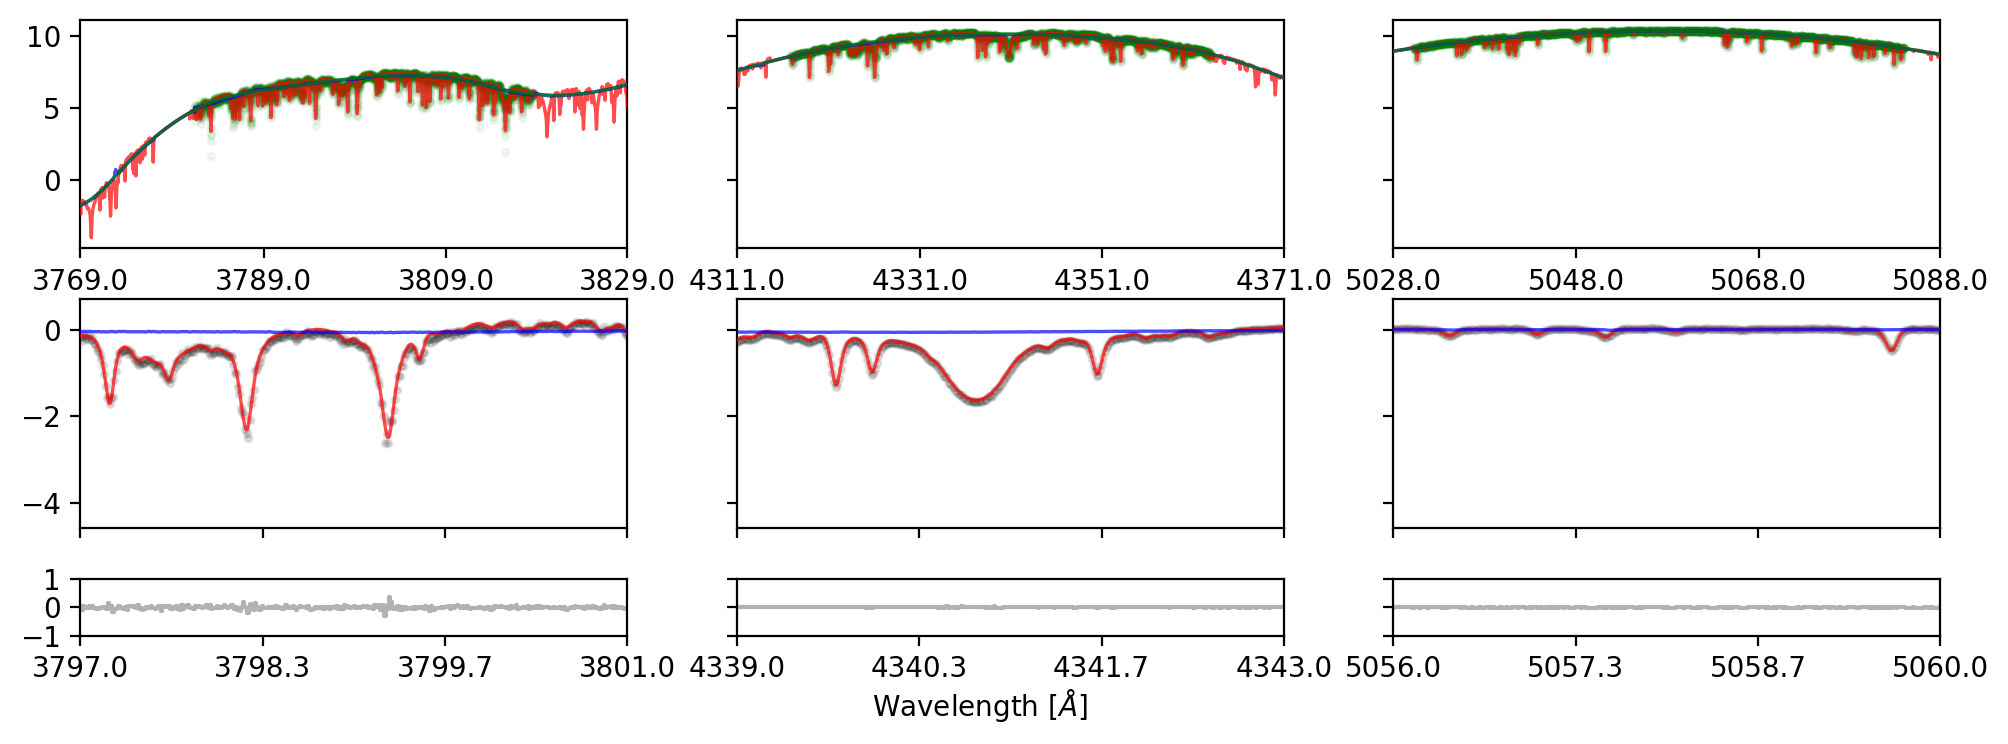

In [48]:
# dataset = jabble.model.load('../out/25-06-23/HD4307/HD4307_data_o67-67_norm.pkl')
# model = jabble.model.load('../out/25-06-23/HD4307/HD4307_model_o67-67_norm.pkl')

def this_fucking_plot(dataset,model):
    rv_inds = [np.argmin(dataset.metadata['bcs']),np.argmax(dataset.metadata['bcs']),0,1,2,3]
    
    plt_epoches = [0,np.argmin(dataset.metadata['bcs']),np.argmax(dataset.metadata['bcs'])]
    plt_width = np.arange(-10,10,4)
    lrange = np.array([np.mean(np.exp(dataset[plt_epoch].xs)) for plt_epoch in plt_epoches]).astype(int)[None,:] + plt_width[:,None]
    fig, axes = plt.subplots(3,len(plt_epoches),figsize=(4*len(plt_epoches),8),sharex='col',sharey='row',\
                                 facecolor=(1, 1, 1),height_ratios=[4,1,4,1],dpi=200)
    
    # lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
    model.fit()
    model.display()
    
    plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
    print(axes.shape)
    for ii in range(axes.shape[1]):
        axes[:2,ii] = make_subplot_norm(axes[:1,ii],model,dataset,plt_epoches[0],cpus[0],lrange[:,ii])
    # plt.show()
    
    # fig, axes = plt.subplots(2,len(plt_epoches),figsize=(4*len(plt_epoches),4),sharex='col',sharey='row',\
    #                              facecolor=(1, 1, 1),height_ratios=[4,1],dpi=200)
    
    # lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
    model.fit()
    model.display()
    
    plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
    print(axes.shape)
    for ii in range(axes.shape[1]):
        axes[2:,ii] = make_subplot(axes[1:,ii],model,dataset,plt_epoches[0],cpus[0],lrange[:,ii])
    plt.show()

def make_subplot_norm(axes,model,dataset,norm_dataset,plt_epoch,device,lrange):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)

    # ndata,nmeta = norm_dataset.blockify(device)
    # ndatarow = jabble.loss.dict_ele(ndata,plt_epoch,device)
    # nmetarow = jabble.loss.dict_ele(nmeta,plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    yplot_norm_stel = model[0]([],xplot,metarow)
    yplot_norm_tell = model[1]([],xplot,metarow)
    yplot_norm      = model[2]([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)
    axes.set_xlim(xplot.min(),xplot.max())

    velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes.errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]],\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.g',zorder=2,alpha=0.05,ms=5)

    # axes.errorbar(ndatarow["xs"][~ndatarow["mask"]],ndatarow["ys"][~ndatarow["mask"]],\
    #                  yerr=1/np.sqrt(ndatarow["yivar"][~ndatarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)

    # Stellar Model        
    axes.plot(xplot,yplot_norm_stel + yplot_norm,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Telluric M
    axes.plot(xplot,yplot_norm_tell + yplot_norm,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    axes.plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    # axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
    #                          'k',where='mid',zorder=1,alpha=0.3,ms=3)

    # if "orders" in model.metadata:
        
    #     axes[0].text(np.log(lrange.min()+0.1),0.3,"Order: ${}$".format(model.metadata["orders"][plt_epoch]))
    # axes[0].text(np.log(lrange.max()-0.1),0.3,"MJD: ${}$".format(model.metadata["times"][plt_epoch]))

    # axes[0].set_ylim(-2.5,0.5)
    # axes.set_ylim(-1,1)
    
    # axes[0].set_xticks([])
    axes.set_xticks(np.log(lrange))
    # axes[1].set_xticks(np.log(lrange))

    # axes.set_xticklabels(['' for x in lrange])
    axes.set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes.set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    # axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

def make_subplot(axes,model,dataset,plt_epoch,device,lrange):

    model.fix()
    data, meta, keys = dataset.blockify(device,return_keys=True)
    
    datarow = jabble.loss.dict_ele(data,plt_epoch,device)
    metarow = jabble.loss.dict_ele(meta,plt_epoch,device)
    # fig.suptitle("Order {}".format(keys["orders"][meta["orders"][plt_epoch]]))
    # axes[0,ii].title.set_text('Date: {}'.format(keys["times"][meta["times"][plt_epoch]]))

    # print(metarow['index'],plt_epoch)
    
    xplot = np.linspace(np.log(lrange.min()),np.log(lrange.max()),\
                        dataset.xs[plt_epoch].shape[0]*10)

    yplot_norm_tot  = model([],xplot,metarow)
    yplot_norm_stel = model[0]([],xplot,metarow)
    yplot_norm_tell = model[1]([],xplot,metarow)
    # yplot_norm      = model[2]([],xplot,metarow)
    # for epoch in np.where(indices):
    yhat_norm = model[2]([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)
    yhat = model([],dataset.xs[plt_epoch][~datarow["mask"]],metarow)

    axes[0].set_xlim(xplot.min(),xplot.max())

    # velocity = jabble.physics.velocities(model[0][0].p[plt_epoch])
    
    # Data
    # print(datarow)
    axes[0].errorbar(datarow["xs"][~datarow["mask"]],datarow["ys"][~datarow["mask"]] - yhat_norm,\
                     yerr=1/np.sqrt(datarow["yivar"][~datarow["mask"]]),fmt='.k',zorder=2,alpha=0.1,ms=5)

    # Stellar Model        
    axes[0].plot(xplot,yplot_norm_stel,'-r',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Telluric M
    axes[0].plot(xplot,yplot_norm_tell,'-b',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Total
    # axes[0].plot(xplot,yplot_norm_tot,'-m',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Norm
    # axes[0].plot(xplot,yplot_norm,'-g',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # Theory Model
    # theory_ax = axes[0,ii].twinx()
    # theory_ax.plot(dataset_theory.xs[0][:],dataset_theory.ys[0][:],'-y',linewidth=1.2,zorder=10,alpha=0.7,ms=6)
    # theory_ax.set_ylim(-5,5)
    # Line List
 
    # Residuals
    axes[1].step(dataset.xs[plt_epoch][~datarow["mask"]],dataset.ys[plt_epoch][~datarow["mask"]] - yhat,\
                             'k',where='mid',zorder=1,alpha=0.3,ms=3)

    

    # axes[0].set_ylim(-2.5,0.5)
    axes[1].set_ylim(-1,1)
    
    # axes[0].set_xticks([])
    axes[0].set_xticks(np.log(lrange))
    axes[1].set_xticks(np.log(lrange))

    axes[0].set_xticklabels(['' for x in lrange])
    axes[1].set_xticklabels(['{:0.1f}'.format(x) for x in lrange])
    
    axes[0].set_xlim(np.log(lrange.min()),np.log(lrange.max()))
    axes[1].set_xlim(np.log(lrange.min()),np.log(lrange.max()))

    return axes

import jabble.plotting
print(len(all_models),len(all_data))
all_models[0].display()
# rv_inds = [np.argmin(dataset.metadata['bcs']),np.argmax(dataset.metadata['bcs']),0,1,2,3]

plt_epoches  = [0,np.argmin(all_data[0].metadata['bcs']),np.argmax(all_data[0].metadata['bcs'])]
data_indices = [0,10,20]

plt_width_n = np.linspace(-30,30,4)
plt_width = np.linspace(-2,2,4)

lrange   = np.array([np.mean(np.exp(all_data[data_i][plt_epoch].xs)) for plt_epoch,data_i in zip(plt_epoches,data_indices)]).astype(int)[None,:] + plt_width[:,None]
lrange_n = np.array([np.mean(np.exp(all_data[data_i][plt_epoch].xs)) for plt_epoch,data_i in zip(plt_epoches,data_indices)]).astype(int)[None,:] + plt_width_n[:,None]


fig, axes = plt.subplots(3,len(plt_epoches),figsize=(4*len(plt_epoches),4),sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,4,1],dpi=200)

# lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 
plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
for ii,(plt_epoch,data_i) in enumerate(zip(plt_epoches,data_indices)):
    axes[0,ii]  = make_subplot_norm(axes[0,ii], all_models[data_i],all_data[data_i],None,plt_epoch,cpus[0],lrange_n[:,ii])
    axes[1:,ii] = make_subplot(     axes[1:,ii],all_models[data_i],all_data[data_i],plt_epoch,cpus[0],lrange[:,ii])
plt.subplots_adjust(hspace=0.3)
fig.text(0.5, 0.01, 'Wavelength [$\\AA$]', ha='center')
plt_name = "{}_spectra_d{}.png".format(star_name,data_indices)
plt.savefig(plt_name)
plt.show()

In [20]:
# device_store = cpus[0]
# device_op = cpus[0]
# batch_size = 5000

# # out_dir = '/scratch/mdd423/wobble_jax/out/25-07-09/'
# import copy
# for orders in orders_s:

#     data_name = os.path.join(out_dir,star_name,'{}_data_o{}-{}_norm.pkl'.format(star_name,np.min(orders),np.max(orders)))
#     model_name = os.path.join(out_dir,star_name,'{}_model_o{}-{}_norm.pkl'.format(star_name,np.min(orders),np.max(orders)))
#     if not os.path.isfile(model_name) or True:
#         dataset = get_dataset(e2ds_sci,device_op,orders,star_name,l_index,h_index)
#         # norm_dataset = copy.deepcopy(dataset)
#         # for time in dataset.metadata['times']:
#         #     print(ccf_arr_obj['ccf_rvs'][ccf_arr_obj['times'] == time])
        
#         # bervs    = np.array([ccf_arr_obj['bervs'][ccf_arr_obj['times'] == time][0] for time in dataset.metadata['times']])
#         # hrprvs   = np.array([ccf_arr_obj['ccf_rvs'][ccf_arr_obj['times'] == time][0] for time in dataset.metadata['times']])
#         # hrprvc   = np.array([ccf_arr_obj['ccf_rvc'][ccf_arr_obj['times'] == time][0] for time in dataset.metadata['times']])
#         init_rvs = -ccf_arr_obj['bervs'] - ccf_arr_obj['ccf_rvc']
#         rest_rvs = np.zeros(init_rvs.shape)#ccf_arr_obj['ccf_rvc'] - ccf_arr_obj['ccf_rvs']
#         print(init_rvs.shape,rest_rvs.shape)
#         dataset.metakeys['times'] = ccf_arr_obj['times']
        
#         model =  get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_rvs,dataset.metadata['airmass'])
#         model.display()
#         # norm_model = get_normalization_model(dataset,norm_p_val,norm_pts)
#         # model += norm_model
#         reg_s = lmb*jabble.loss.L2Reg([1]) * np.nansum(dataset.yivar)
#         reg_t = lmb*jabble.loss.L2Reg([1,1]) * np.nansum(dataset.yivar)
#         print(np.nansum(dataset.yivar) * lmb)
#         model.metadata = dataset.metadata

#         loss = jabble.loss.ChiSquare()

#         # model = train_norm(model, norm_dataset, loss, device_store, device_op, batch_size,maxiter=2,nsigma=[0.3,3])
#         model = train_cycle(model, dataset, loss + reg_s + reg_t, device_store, device_op, batch_size)
#         # this_fucking_plot(dataset,model)
#         # shifts = model[0][0].p
#         # model  = get_model(dataset,resolution,p_val,vel_padding,init_rvs,rest_rvs,dataset.metadata['airmass'])
#         # model += norm_model
#         # model[0][0].p = jnp.array(shifts)
#         # model.metadata = dataset.metadata
#         # model = train_cycle(model, dataset, loss + reg_s + reg_t, lmb, device_store, device_op, batch_size)
#         # this_fucking_plot(dataset,model)
#         rv_model = model
#         for ii in [0,0]:
#             rv_model = rv_model[ii]
#         rv_model.display()
        
#         jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,device=device_op,loss=loss,rv_ind=[0,0])
#     else:
#         print('skipping {}'.format(model_name))

# fig, axes = plt.subplots(3,1,figsize=(4*len(model_inds),8),sharex='col',sharey='row',\
#                              facecolor=(1, 1, 1),height_ratios=[4,4,1],dpi=200)


# # plt_width = np.arange(-40,40,20) + 10
# plt_epoch = 0

# lrange = np.linspace(int(np.min(np.exp(dataset[plt_epoch].xs))),int(np.max(np.exp(dataset[plt_epoch].xs))),4)[:,None]
# # lrange = np.array([np.mean(np.exp(dataset[plt_epoch].xs)) for plt_epoch in plt_epoches]).astype(int)[None,:] + plt_width[:,None]

# # lrange = l_plt*np.ones(len(rv_inds))[:,None] + np.arange(-2,2,2)[None,:] 

# plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
# axes[0] = make_subplot_norm(axes[0],model,dataset,norm_dataset,plt_epoches[0],cpus[0],lrange[:,0])

# plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())
# # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
# axes[1:] = make_subplot(axes[1:],model,dataset,plt_epoches[0],cpus[0],lrange[:,0])
# fig.text(0.5, 0.04, 'Wavelength [$\\AA$]', ha='center')
# plt.show()
# # jabble.quickplay.save(model,model_name,data_name,data=dataset,shifts=model[0][0].p,\
# #                                           device=device_op,loss=loss+reg_s+reg_t)

In [35]:
# dir = glob.glob('/scratch/mdd423/wobble_jax/out/25-05-08/barnards/*.pkl')25-06-23/HD4307
summary_path = "/scratch/mdd423/wobble_jax/out/25-07-24/HD4307"
dir_files = glob.glob(os.path.join(summary_path,'*_RVS.hdf'))
print(len(dir_files))
with h5py.File(dir_files[0],'r') as hdf_file:
    print(hdf_file['RV_err'].shape,hdf_file['RVs'].shape,hdf_file['Times'].shape)

rv_array, all_models, all_rv_array, all_data = jabble.quickplay.load_model_dir(summary_path,\
                                                                               dir_files,cpus[0],\
                                                                               force_run=True,\
                                                                               min_info=1e-2,
                                                                              max_info=1e12)

36
(79,) (79,) (79,)


In [23]:
# jabble.plotting.plot_rv_difference(all_rv_array['Time_all'],all_rv_array['RV_all'],all_rv_array['RV_err_all'],\
#                         rv_array['Time_comb'],rv_array['RV_comb'],rv_array['RV_err_comb'],\
#                         ccf_arr_obj['times'],ccf_arr_obj['ccf_rvs']-ccf_arr_obj['ccf_rvc'],ccf_arr_obj['ccf_drvs'],\
#                         ccf_arr_obj['bervs'],all_rv_array['Loss_Avg'],all_rv_array['RV_difference'],star_name,\
#                                    out_dir=out_dir,sigma_max=5,difference_max=15,chi_max=5,top_spacing=1.2)

In [ ]:
def make_grid_plots(datasets,models,size_n,size_m,plt_epochs,device,line_list=None,l_width=np.arange(-4,4,2)):
    # l_width = 
    
    fig, axes = plt.subplots(2*size_n,size_m,figsize=(3*size_m,2*size_n),sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,1]*size_n,dpi=200)
    # plt.tight_layout()

    for ii, nn in enumerate(range(size_n)):
        for jj, mm in enumerate(range(size_m)):
            this_index = size_m*ii+jj
            
            lrange = np.floor(np.exp(datasets[this_index].xs[plt_epochs[this_index]]).mean()) + l_width
            # print(lrange)
            axes[2*ii:((2*ii)+2),jj] = make_subplot(axes[2*ii:((2*ii)+2),jj],models[this_index],datasets[this_index],plt_epochs[this_index],device,lrange)
            if "orders" in models[this_index].metadata:
        
                text = axes[2*ii,jj].text(np.log(lrange.min()+0.1),-2.4,\
                                          "Order: ${}$".format(models[this_index].metadata["orders"][plt_epochs[this_index]]))
                # text.fontsize = 16
    
            if line_list is not None:
                plot_line_list(axes[2*ii:((2*ii)+2),jj],line_list,lrange)
    plt.subplots_adjust(top=1.3)

    return fig, axes

lmin = [np.exp(np.min(model[1].xs)) for model in all_models]
lmax = [np.exp(np.max(model[1].xs)) for model in all_models]
plt_lambdas = np.array([6300,6565])
model_inds = [np.array(np.where((plt_lambda > lmin) * (plt_lambda < lmax))).squeeze() for plt_lambda in plt_lambdas]
l_means = np.concatenate([[plt_lambdas[ii]]*xx.shape[0] if len(xx.shape) != 0 else [plt_lambdas[ii]] for ii,xx in enumerate(model_inds)])
print(model_inds)
model_inds = np.concatenate([np.array([xx]) if len(xx.shape) == 0 else xx for xx in model_inds])
# model_inds = np.array([0,5,33,35])
# rv_inds = [np.argmin(dataset.metadata['bcs']),np.argmax(dataset.metadata['bcs']),0,1,2,3]
fig, axes = plt.subplots(2,len(model_inds),figsize=(4*len(model_inds),4),sharex='col',sharey='row',\
                             facecolor=(1, 1, 1),height_ratios=[4,1],dpi=200)


plt_width = np.arange(-15,5,5)
lrange = l_means.astype(int)[None,:] + plt_width[:,None]
plt_epoches = [1]
plt_name = "{}_spectra_l{}-{}.png".format(star_name,lrange.min(),lrange.max())

for ii, (dataset, model) in enumerate(zip([ all_data[jj] for jj in model_inds ],[all_models[jj]for jj in model_inds ])): 
    
    # axes[1,ii].text(dataset.metadata['order'][plt_epoches[0]])
    axes[:,ii] = make_subplot(axes[:,ii],model,dataset,plt_epoches[0],cpus[0],lrange[:,ii])
fig.text(0.5, 0.00, 'Wavelength [$\\AA$]', ha='center')
plt.show()

In [ ]:
def plt_rv_comparison(times, rv_e, err_e, times_comb, rv_comb, err_comb, targ_time, targ_vel, \
                      targ_err, bervs, star_name, out_dir):
    epoches_span = np.arange(0, len(times_comb), dtype=int)

    # RV Comparison

    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )
    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times_comb))


    bervs_temp = -bervs[targ_ind][comb_indi] + bervs.mean()
    norm_vel   = bervs_temp

    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times_comb))

    bervs_temp = -bervs[targ_ind][comb_indi] + bervs.mean()
    norm_vel   = bervs_temp #(targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean())
    # print(np.sum(times_comb == targ_time[targ_ind][comb_indi]))

    targ_norm = (targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean()) - norm_vel
    targ_line = ax.errorbar(epoches_span,targ_norm,targ_err[targ_ind][comb_indi],fmt='.g',zorder=3,alpha=0.5,ms=2,label='CCF RV')

    
    comb_norm = (rv_comb - rv_comb.mean()) - norm_vel
    comb_line = ax.errorbar(epoches_span,comb_norm,err_comb,fmt='.r',zorder=2,alpha=0.3,ms=2,label='Order Jabble Combined RV')

    temp_vel = (rv_e.mean(axis=0) - rv_e.mean()) #+ bervs_temp[targ_ind][comb_indi]
    avg_line = ax.errorbar(epoches_span,temp_vel,0.0,fmt='.b',zorder=2,alpha=0.0,ms=2,label='Avg RV')

    for i in range(rv_e.shape[0]):
        e_ind = np.argsort(times[i,:])
        indiv_norm = (rv_e[i,:][e_ind][comb_indi] - rv_e[i,:].mean()) - norm_vel
        # times[i,:][e_ind][comb_indi]
        err_line = ax.errorbar(epoches_span,indiv_norm,yerr=err_e[i,:][e_ind][comb_indi],fmt='.k',zorder=1,alpha=0.03,ms=2,label='Order Jabble RV')

    # ax.set_ylim(-100, 100)
    ax.legend(handles=[targ_line,comb_line,err_line],loc="upper right")

    # ax.set_title('Barnard\'s Star Relative Radial Velocities')
    ax.set_ylabel("RV [$m/s$]")
    ax.set_xlabel( "Epochs")
    # ax.set_xlim(2.456e6 + 451,2.456e6+452)
    ax.set_ylim(-50,50)
    # plt.savefig(os.path.join(out_dir, "{}_rvs_epoch.png".format(star_name)),bbox_inches='tight')
    plt.show()


plt_rv_comparison(all_rv_array['Time_all'], all_rv_array['RV_all'], all_rv_array['RV_err_all'],\
                  rv_array['Time_comb'], rv_array['RV_comb'], rv_array['RV_err_comb'],\
                  ccf_arr_obj['times'], ccf_arr_obj['ccf_rvs'] - ccf_arr_obj['bervs'], \
                  ccf_arr_obj['ccf_drvs'], ccf_arr_obj['bervs'], star_name, out_dir)


<h2>fit with only stellar model!</h2>

In [ ]:
def plot_rv_error(times,err_e,times_comb,err_comb,targ_time,\
                  targ_err,star_name,\
                  out_dir):
    
    epoches_span = np.arange(0,len(times_comb),dtype=int)

    # RV Err Comparison
    
    fig, ax = plt.subplots(
        1,
        figsize=(10, 4),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True
    )
    targ_ind = np.argsort(targ_time)
    comb_indi = np.argsort(np.argsort(times_comb))

    # bervs_temp = -bervs[targ_ind][comb_indi] + bervs.mean()
    # norm_vel   = bervs_temp #(targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean())
    # print(np.sum(times_comb == targ_time[targ_ind][comb_indi]))

    # targ_norm  = (targ_vel[targ_ind][comb_indi] - targ_vel[targ_ind][comb_indi].mean()) - norm_vel
    targ_line = ax.plot(epoches_span,targ_err[targ_ind][comb_indi],'.g',zorder=3,alpha=0.5,ms=2,label='HARPS RV')

    
    # comb_norm = (rv_comb - rv_comb.mean()) - norm_vel
    comb_line = ax.plot(epoches_span,err_comb,'.r',zorder=1,alpha=0.3,ms=2,label='Order Jabble Combined RV')

    # ax.set_title('Barnard\'s Star Relative Radial Velocity Error')
    ax.set_ylabel("RV Error [$m/s$]")
    ax.set_xlabel( "Epochs")
    # ax.set_xlim(2.4564e6,2.45644e6)
    # ax.set_ylim(-1e2,1e2)
    # plt.savefig(os.path.join(out_dir, "{}_rvs_err_epoch.png".format(star_name)),bbox_inches='tight')
    plt.show()
    


In [ ]:
# , all_rv_array['RV_all'], ],\
#                   , rv_array['RV_comb'], ,\
#                   , ccf_arr_obj['ccf_rvs']/1000 -  ccf_arr_obj['bervs'], \
#                   , ccf_arr_obj['bervs'], star_name, out_dir
plot_rv_error(all_rv_array['Time_all'],all_rv_array['RV_err_all'],rv_array['Time_comb'],\
              rv_array['RV_err_comb'],ccf_arr_obj['times'],\
              ccf_arr_obj['ccf_drvs'],star_name,out_dir)

In [ ]:
ccf_arr_obj['ccf_rvs'] - ccf_arr_obj['ccf_rvs'].mean()

In [ ]:
temp = rv_array['RV_comb'] + ccf_arr_obj['bervs']
print(temp - temp.mean())